# Passer-classifier

The goal of this project is to create classifier that can separate individuals between two sparrow species: *Passer montanus* and *Passer domesticus*. I intend to use only male individuals here, but the code is extendable for female individuals also, but that might be less performant than the one with only male individuals.

I aim to do this project quick and dirty using fastai's awesome library that runs on top of PyTorch. I love the philosophy behind the fastai library and I intend to use it in the future as well. Let's start by importing the main components from fastai that we need for creating the classifier.

Oh, btw, my approach here is to use CNN based on popular CNN architectures such as ResNet

In [1]:
from fastai.vision import *

Before I proceed, I'd like to check what kind of device I'm working with before training the model. As of writing this, I'm using my own PC with RTX 2080 GPU, as we should see here

In [2]:
import torch
torch.cuda.get_device_name(0)

'GeForce RTX 2080'

# Download images for classifier

## Get a list of URLs

To start this process fire up the Google Image search and type in the search words you're after. In my case I typed this into search field:

`"passer montanus" -female`

Most of the search results look pretty ok to me, but don't worry, we'll come back to clean up the dataset a bit later on. As a side note, you can see maximum number of 700 pictures in search, so that is the upper limit for our dataset size for each label. I intend to work with a bit smaller dataset, let's say 400 images for each Google Image search



### Download into file

Now we run some Javascript code in browser which will save the URLs of all the images we want for our dataset. Fire up the developer tool in your browser and paste this code there:

`urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

Make sure that you disable your adblocker before running the above code. Running the code downloads the file to your downloads folder

### Create a directory and upload urls file into your machine

In [13]:
folder = 'passer-montanus'
file = 'passer_montanus.csv'

In [17]:
folder = 'passer-domesticus'
file = 'passer_domesticus.csv'

Then run this cell once per each category

In [18]:
path = Path('data/birds')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [19]:
path.ls()

[PosixPath('data/birds/passer-domesticus'),
 PosixPath('data/birds/passer_domesticus.csv'),
 PosixPath('data/birds/passer-montanus'),
 PosixPath('data/birds/passer_montanus.csv')]

## Download images

fast.ai has a function that downloads files from respective urls. We just have to specify the urls filename as well as the destination folder and this function will download all images that can be opened. If they have some problem in being opened, they will not be save

Run this line once for every category

In [10]:
classes = ['passer-montanus', 'passer-domesticus']

In [20]:
download_images(path/file, dest, max_pics=400)

Remove images that can't be opened:

In [21]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [22]:
np.random.seed(2020)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Take a look at the classes and pictures

In [23]:
data.classes

['passer-domesticus', 'passer-montanus']

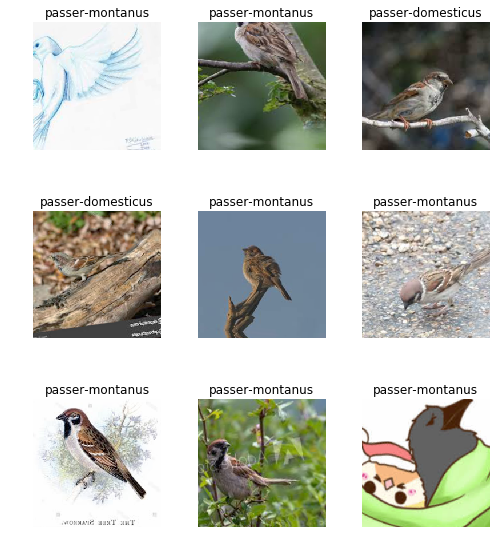

In [24]:
data.show_batch(rows=3, figsize=(7,8))

Here we see below:
- Class labels
- Number of labels
- Training set size
- Validation set size

In [25]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['passer-domesticus', 'passer-montanus'], 2, 512, 128)

# Train model

We use pretrained ResNet model and with fast.ai this is super simple and doesn't take that many lines to train the data. Note here, that we don't need to write CNN architecture because we are using pretrained ResNet model with architecture defined by that model. We can use different models than ResNet, but ResNet34 feels like a good starting point here. If our model over- or underfits significantly we can then think about different models

In [28]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.944626,0.590921,0.328125,00:01
1,0.733043,0.502569,0.226562,00:01
2,0.641286,0.501471,0.226562,00:01
3,0.563330,0.496308,0.210938,00:01
4,0.513868,0.499494,0.210938,00:01


Pretty promising results so far with couple of lines with code. At this moment based on those metrics we don't significantly over- or underfit and our model is pretty accurate (79%). Let's save our model with simple command:

In [30]:
learn.save('stage-1')

Now we make all layers available for training by unfreezing the layers making it possible to update weights to all layers

In [31]:
learn.unfreeze()

Find the best learning rate for underlying data:

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


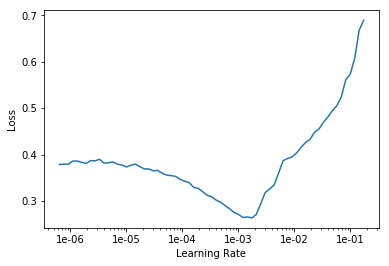

In [33]:
learn.recorder.plot()

On the learning rate finder, we are looking for the strongest downward slope that's kind of sticking around for quite a while. This is something you just need a practice on - practice makes perfect!

In [34]:
learn.fit_one_cycle(5, max_lr=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.411400,0.867486,0.289062,00:02
1,0.413690,2.437496,0.382812,00:02
2,0.391373,0.663021,0.164062,00:02
3,0.332132,0.553556,0.187500,00:02
4,0.270104,0.431214,0.164062,00:02


We gained a bit better classifier here as our error_rate went down from 21% to around 16%. Slight improvement, but I'll take it anyway! Let's save this classifier

In [35]:
learn.save('stage-2')

## Interpretation

Let's plot simple confusion matrix to see how our model performed

In [36]:
learn.load('stage-2');

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

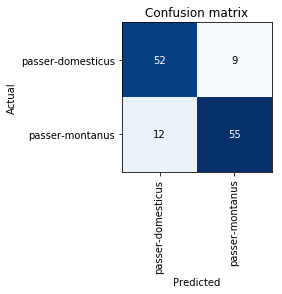

In [38]:
interp.plot_confusion_matrix()

Let's see some examples what labels our classifier puts on iamges

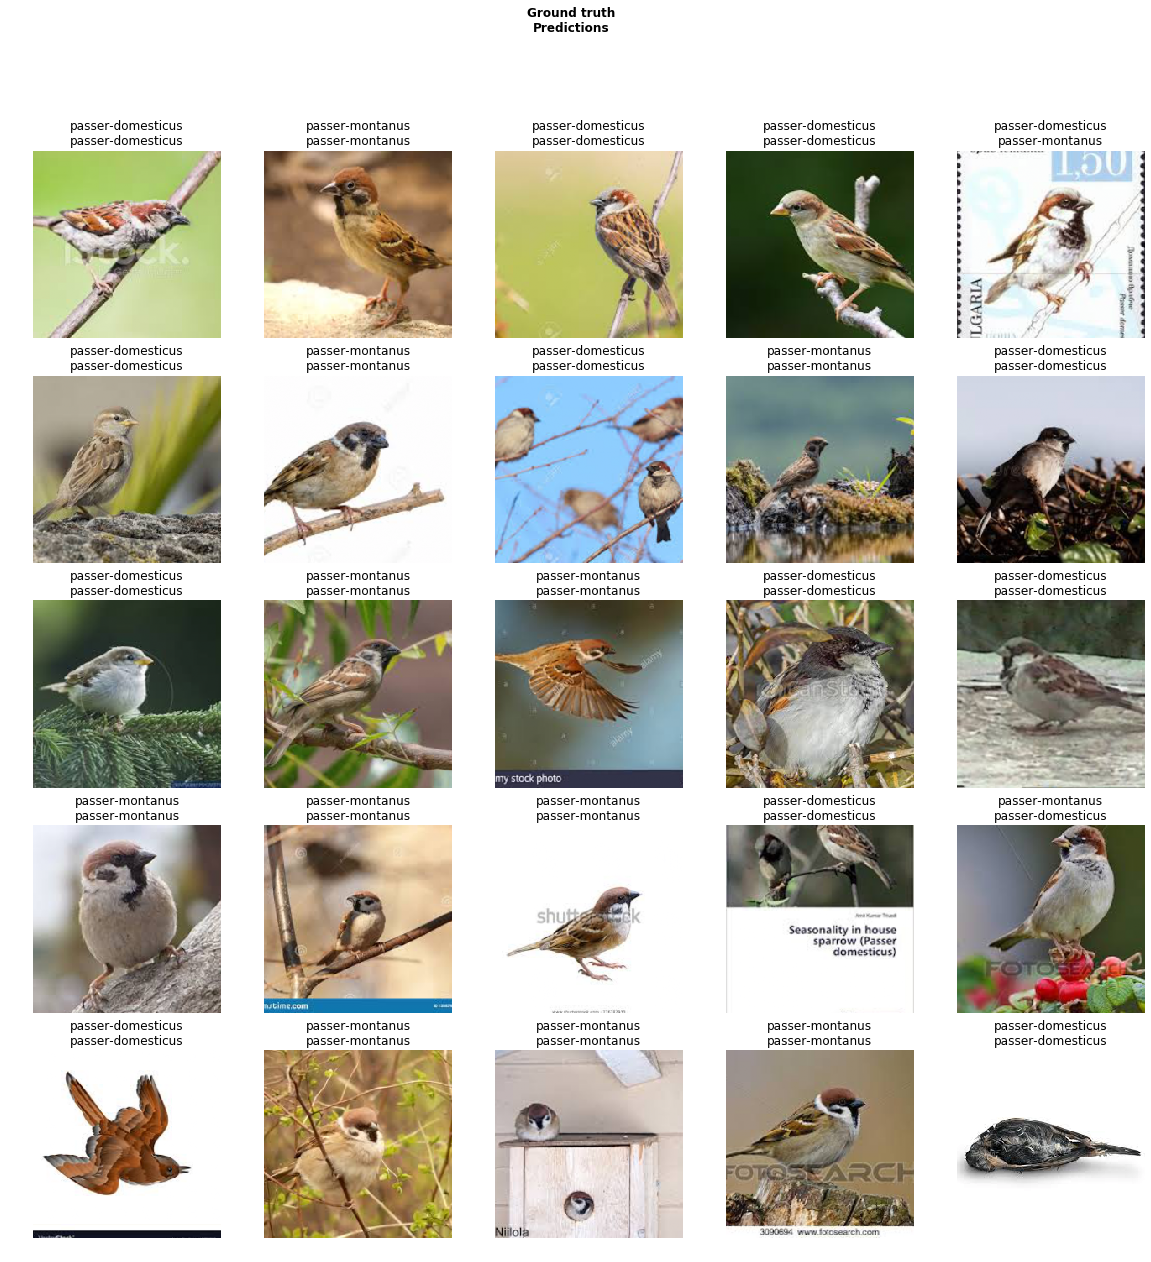

In [39]:
learn.show_results()

# Cleaning up